# Module 4.A Probability Fundamentals on NYC 311

This module applies the **Module 4.A** ideas to the NYC 311 feature table  
* **Random variables:** define events as boolean random variables (0/1)
* **Marginals:** compute baseline rates like `P(fast)`
* **Conditionals:** compute `P(fast | noise)` vs `P(noise | fast)` and interpret denominators
* **Bayes reversal:** relate `P(A|B)` and `P(B|A)` using empirical counts

**Deliverable:**  
A short written narrative describing one probability story that was discovered

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

rng = np.random.default_rng(42)

## 4A.1 Load the normalized NYC 311 table - From 3.A

In [2]:
M3_DATA_DIR = Path("work/m3/data")
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

if not NORM_PATH.exists():
    raise FileNotFoundError(
        f"Missing normalized cache at {NORM_PATH}. "
        "Run Module 3.A first to create it."
    )

df = pd.read_parquet(NORM_PATH)
print("Loaded:", NORM_PATH)
print("Shape:", df.shape)
df.head(3)


Loaded: work/m3/data/nyc311_features_norm.parquet
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet,4


## 4A.2 Define an analysis slice - so probabilities are meaningful

Probability statements are only as meaningful as the population you compute them on.  

For this section, we will:  
* focus on **closed cases**, where `resolution_hours` is observed
* require a sane, non-negative `resolution_hours`
* explicitly acknowledge **right-censoring**: near the end of the time window, long-running cases may still be open.

If `P(fast)` is computed over all rows (including open cases), the "observed outcomes" and "unknown outcomes" are being mixed. That is rarely the problem that should be looked at.

In [3]:
df2 = df.copy()

# Determine closed cases (robust to different schemas)
if "is_closed" in df2.columns:
    is_closed = df2["is_closed"] == 1
elif "status" in df2.columns:
    is_closed = df2["status"].astype(str).str.upper().isin(["CLOSED", "RESOLVED"])
else:
    is_closed = pd.Series([True] * len(df2), index=df2.index)

if "resolution_hours" not in df2.columns:
    raise ValueError("Expected 'resolution_hours' to exist (created in earlier modules / normalized in 3.A).")

y = df2["resolution_hours"].astype(float)

mask = is_closed & y.notna() & np.isfinite(y) & (y >= 0)
d = df2.loc[mask].copy()

print("Closed + valid resolution_hours slice:")
print("Shape:", d.shape)
d[["agency", "borough_norm", "complaint_topk", "resolution_hours"]].head(5)


Closed + valid resolution_hours slice:
Shape: (18894, 25)


,agency,borough_norm,complaint_topk,resolution_hours
41,NYPD,BRONX,noise - residential,0.373056
43,NYPD,QUEENS,illegal parking,0.181667
45,NYPD,QUEENS,illegal parking,0.353056
49,NYPD,BRONX,other,0.300278
51,NYPD,MANHATTAN,other,0.095000


### Quick sanity check: How heavy is the tail?  

Tail heaviness impacts how stable probabilities are; especially for thresholds like "resolved within 24 hours."

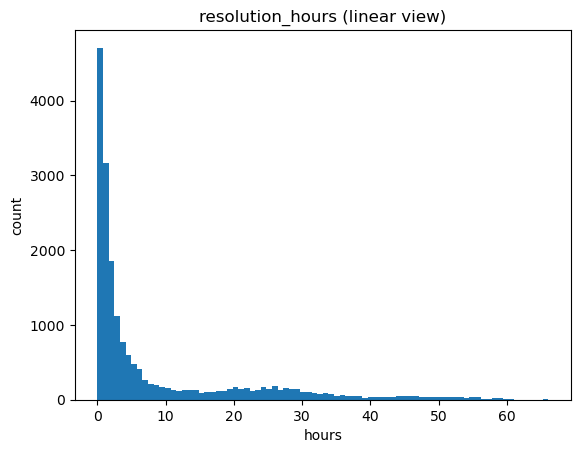

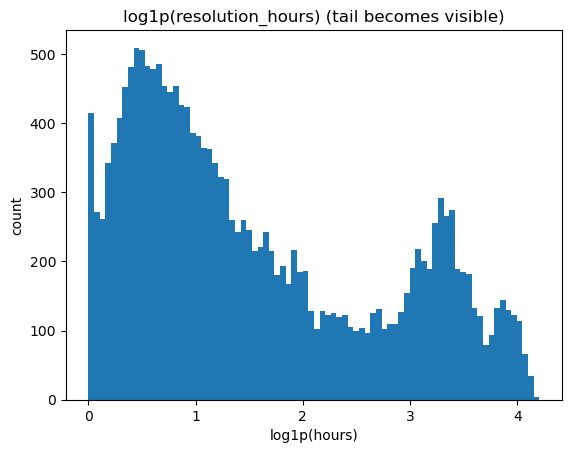

In [4]:
plt.figure()
plt.hist(d["resolution_hours"], bins=80)
plt.title("resolution_hours (linear view)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(d["resolution_hours"]), bins=80)
plt.title("log1p(resolution_hours) (tail becomes visible)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

## 4A.3 Define events - boolean random variables  

We will create a few events that can be reused throughout Module 4:  
* `fast_24`: resolved within 24 hours
* `fast_72`: resolved within 72 hours
* `noise`: a noise complaint indicator
* `rodent`: rodent-related indicator

**Important:**  
Event definitions are part of the *data contract*. Small definition changes can flip conclusions.

In [5]:
# Event: fast resolution
d["fast_24"] = d["resolution_hours"] <= 24
d["fast_72"] = d["resolution_hours"] <= 72

# Event: noise complaint (use the most reliable signal available)
if "kw_noise" in d.columns:
    d["noise"] = d["kw_noise"].astype(int) == 1
else:
    # Fall back to complaint_topk text match if keyword feature doesn't exist
    ct = d["complaint_topk"].astype(str).str.lower()
    d["noise"] = ct.str.contains("noise")

# Event: rodent complaint (nice for base-rate demonstrations)
if "kw_rodent" in d.columns:
    d["rodent"] = d["kw_rodent"].astype(int) == 1
else:
    ct = d["complaint_topk"].astype(str).str.lower()
    d["rodent"] = ct.str.contains("rodent|rat|mice|mouse")

# A quick look at event prevalence
event_cols = ["fast_24", "fast_72", "noise", "rodent"]
d[event_cols].mean().sort_values(ascending=False)

fast_72    1.000000
fast_24    0.853975
noise      0.099608
rodent     0.003811
dtype: float64

## 4A.4 Marginal probabilites - baseline rates

A **marginal probability** is just the baseline rate in the chosen population.  

Examples:
* `P(fast_24)`: fraction of closed cases resolved within 24 hours
* `P(noise)`: fraction of closed cases that are noise-related

These are the base rates that anchor interpretation.

In [6]:
def p(series: pd.Series) -> float:
    """Probability estimate for a boolean (or 0/1) series."""
    s = series.astype(bool)
    return float(s.mean())

marginals = pd.Series({
    "P(fast_24)": p(d["fast_24"]),
    "P(fast_72)": p(d["fast_72"]),
    "P(noise)": p(d["noise"]),
    "P(rodent)": p(d["rodent"]),
}).sort_values(ascending=False)

marginals

P(fast_72)    1.000000
P(fast_24)    0.853975
P(noise)      0.099608
P(rodent)     0.003811
dtype: float64

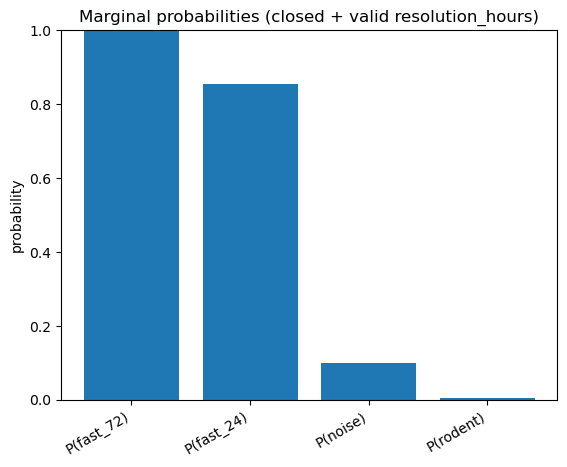

In [7]:
# Visualize marginals
plt.figure()
plt.bar(marginals.index, marginals.values)
plt.title("Marginal probabilities (closed + valid resolution_hours)")
plt.ylabel("probability")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, min(1.0, max(marginals.values) * 1.15 + 0.02))
plt.show()


## 4A.5 Conditional probabilities - denominators matter  

Conditional probability answers:  

Among cases where **B** is true, how often is **A** true?  

We will compare: 
* `P(fast_24 | noise)` vs `P(noise | fast_24)`

A reliable workflow is:
* Build a contingency table
* Compute row/column-normalized rates with explicit denominators

In [8]:
def conditional(A: pd.Series, B: pd.Series) -> float:
    """Compute P(A | B) on booleans A, B with safe handling."""
    A = A.astype(bool)
    B = B.astype(bool)
    denom = B.sum()
    if denom == 0:
        return float("nan")
    return float((A & B).sum() / denom)

A = d["fast_24"]
B = d["noise"]

p_fast_given_noise = conditional(A, B)
p_noise_given_fast = conditional(B, A)

print("P(fast_24 | noise) =", p_fast_given_noise)
print("P(noise | fast_24) =", p_noise_given_fast)


P(fast_24 | noise) = 0.9814027630180658
P(noise | fast_24) = 0.11447164549116827


In [9]:
# Contingency table for (noise, fast_24)
ct = pd.crosstab(d["noise"], d["fast_24"], rownames=["noise"], colnames=["fast_24"])
ct


fast_24,False,True
noise,,
False,2724,14288
True,35,1847


In [10]:
# Convert contingency table to conditional probabilities
# Row-normalized: P(fast_24 | noise)
row_norm = ct.div(ct.sum(axis=1), axis=0)

# Column-normalized: P(noise | fast_24)
col_norm = ct.div(ct.sum(axis=0), axis=1)

print("Row-normalized (P(fast_24 | noise)):")
display(row_norm)

print("\nColumn-normalized (P(noise | fast_24)):")
display(col_norm)

Row-normalized (P(fast_24 | noise)):


fast_24,False,True
noise,,
False,0.160122,0.839878
True,0.018597,0.981403



Column-normalized (P(noise | fast_24)):


fast_24,False,True
noise,,
False,0.987314,0.885528
True,0.012686,0.114472


### Visual intuition: Same table, different denominators  

Now visualize the row-normalized table as a simple heatmap

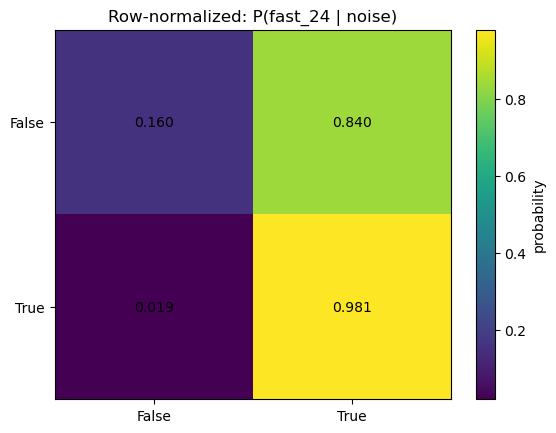

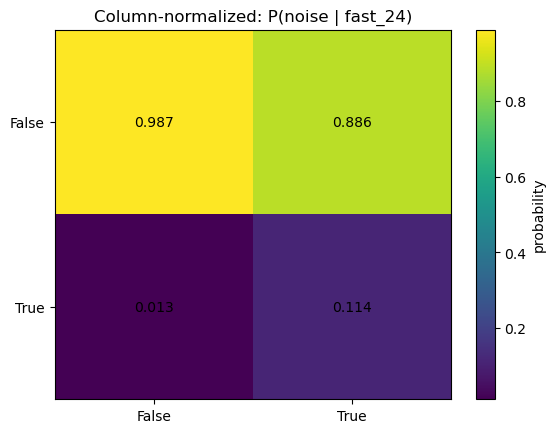

In [11]:
# Simple heatmap helper
def heatmap(df_heat: pd.DataFrame, title: str):
    plt.figure()
    arr = df_heat.to_numpy()
    plt.imshow(arr, aspect="auto")
    plt.title(title)
    plt.xticks(range(df_heat.shape[1]), [str(c) for c in df_heat.columns])
    plt.yticks(range(df_heat.shape[0]), [str(i) for i in df_heat.index])
    plt.colorbar(label="probability")
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            plt.text(j, i, f"{arr[i, j]:.3f}", ha="center", va="center")
    plt.show()

heatmap(row_norm, "Row-normalized: P(fast_24 | noise)")
heatmap(col_norm, "Column-normalized: P(noise | fast_24)")

## 4A.6 Bayes-style reversal - using empirical counts

Bayes' theorem says:
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

With data, we can compute each term empirically and verify the relationship.
* `A = noise`
* `B = fast_24`

Then check:
$$P(noise | fast) \approx \frac{P(fast\_24 | noise) \cdot P(noise)}{P(fast\_24)}$$

If there is a mismatch, it is usually due to 
* sampling noise (small counts)
* inconsistent slicing (different denominators)
* missingness / filtering differences

In [12]:
P_noise = p(d["noise"])
P_fast = p(d["fast_24"])

P_fast_given_noise = conditional(d["fast_24"], d["noise"])
P_noise_given_fast_direct = conditional(d["noise"], d["fast_24"])

# Bayes reversal estimate
P_noise_given_fast_bayes = (P_fast_given_noise * P_noise) / P_fast if P_fast > 0 else float("nan")

print("Empirical terms:")
print("P(noise) =", P_noise)
print("P(fast_24) =", P_fast)
print("P(fast_24 | noise) =", P_fast_given_noise)
print("\nDirect:  P(noise | fast_24) =", P_noise_given_fast_direct)
print("Bayes:   P(noise | fast_24) =", P_noise_given_fast_bayes)
print("\nAbsolute difference =", abs(P_noise_given_fast_direct - P_noise_given_fast_bayes))


Empirical terms:
P(noise) = 0.0996083412723616
P(fast_24) = 0.8539748068169789
P(fast_24 | noise) = 0.9814027630180658

Direct:  P(noise | fast_24) = 0.11447164549116827
Bayes:   P(noise | fast_24) = 0.11447164549116827

Absolute difference = 0.0


### Where does Bayes reversal matter most?  

Bayes reversal can become confusing when **base rates are tiny**. 

We will repeat the exercise with a rare event (`rodent`), which tends to create larger gaps between:  
* How often do rodent cases resolve fast: `P(fast_24 | rodent)`
* Among fast-resolved cases, how often are they rodent: `P(rodent | fast_24)`



In [13]:
def bayes_report(A_name: str, A: pd.Series, B_name: str, B: pd.Series) -> pd.Series:
    A = A.astype(bool)
    B = B.astype(bool)
    PA = p(A)
    PB = p(B)
    PB_given_A = conditional(B, A)
    PA_given_B_direct = conditional(A, B)
    PA_given_B_bayes = (PB_given_A * PA) / PB if PB > 0 else float("nan")

    return pd.Series({
        "P(A)": PA,
        "P(B)": PB,
        "P(B|A)": PB_given_A,
        "P(A|B) direct": PA_given_B_direct,
        "P(A|B) via Bayes": PA_given_B_bayes,
        "abs diff": abs(PA_given_B_direct - PA_given_B_bayes),
        "A": A_name,
        "B": B_name,
    })

rep_noise = bayes_report("noise", d["noise"], "fast_24", d["fast_24"])
rep_rodent = bayes_report("rodent", d["rodent"], "fast_24", d["fast_24"])

pd.DataFrame([rep_noise, rep_rodent])[["A","B","P(A)","P(B)","P(B|A)","P(A|B) direct","P(A|B) via Bayes","abs diff"]]


,A,B,P(A),P(B),P(B|A),P(A|B) direct,P(A|B) via Bayes,abs diff
0,noise,fast_24,0.099608,0.853975,0.981403,0.114472,0.114472,0.0
1,rodent,fast_24,0.003811,0.853975,0.791667,0.003533,0.003533,0.0


## 4A.7 Probability story mining: segment by group  

A common workflow in ML is: 
1. compute baseline rates
2. compute conditional rates by subgroup
3. identify where the story changes

Compute `P(fast_24 | group)` by `agency`

In [14]:
group_col = "agency" if "agency" in d.columns else None
if group_col is None:
    raise ValueError("Expected an 'agency' column in your NYC 311 feature table.")

rates = (
    d.groupby(group_col)["fast_24"]
     .mean()
     .sort_values(ascending=False)
)

rates.head(10)

agency
NYPD     0.999738
DEP      0.926864
DOT      0.912583
DOB      0.857143
DOE      0.853333
DPR      0.851485
DOHMH    0.760000
DCWP     0.750000
DHS      0.709251
TLC      0.655172
Name: fast_24, dtype: float64

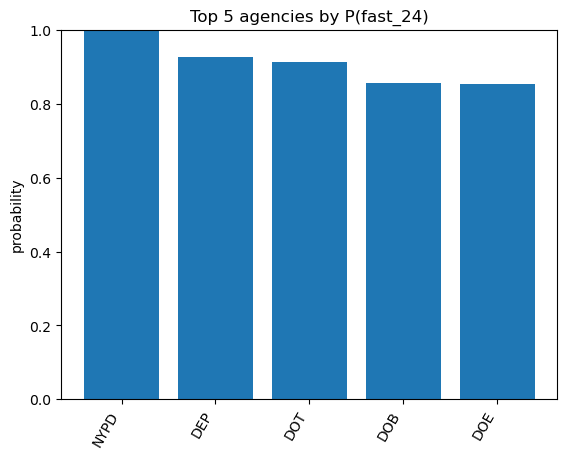

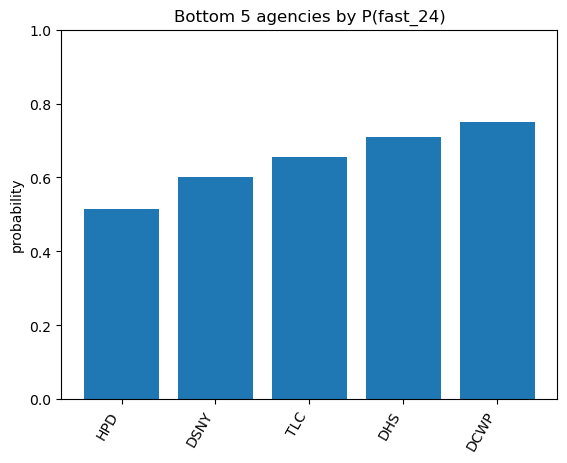

In [15]:
# Plot the top/bottom agencies by P(fast_24)
top_n = 5
top = rates.head(top_n)
bot = rates.tail(top_n).sort_values(ascending=True)

plt.figure()
plt.bar(top.index.astype(str), top.values)
plt.title(f"Top {top_n} agencies by P(fast_24)")
plt.ylabel("probability")
plt.xticks(rotation=60, ha="right")
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.bar(bot.index.astype(str), bot.values)
plt.title(f"Bottom {top_n} agencies by P(fast_24)")
plt.ylabel("probability")
plt.xticks(rotation=60, ha="right")
plt.ylim(0, 1)
plt.show()

### Add conditioning: is the "fast" story different for noise?  

Compute `P(fast_24 | noise, agency)` and compare it with `P(fast_24 | agency)`  

This helps separate:
* "the agency is slow overall" from
* "the agency handles a harder mix of cases"

In [16]:
# P(fast_24 | agency) baseline already computed as `rates`
baseline = rates.rename("P(fast_24 | agency)")

# Condition on noise
dn = d.loc[d["noise"]].copy()
rates_noise = dn.groupby("agency")["fast_24"].mean().rename("P(fast_24 | noise, agency)")

comparison = (
    pd.concat([baseline, rates_noise], axis=1)
      .dropna()
)
comparison["delta (noise - baseline)"] = comparison["P(fast_24 | noise, agency)"] - comparison["P(fast_24 | agency)"]
comparison.sort_values("delta (noise - baseline)").head(12)


,P(fast_24 | agency),"P(fast_24 | noise, agency)",delta (noise - baseline)
agency,,,
DEP,0.926864,0.779874,-0.146989
NYPD,0.999738,1.000000,0.000262


## 4A.8 Deliverable: Write the probability story

Write a short narrative:
* What population was chosen (the slice)?
* What events were defined, and why?
* What were the most important base rates?
* Which conditional probability was most decision-relevant, and why?
* Where did Bayes reversal create the biggest difference in intuition?
* What should be done differently in a modeling pipeline because of this?

Complete the following template

### My NYC311 probability story  

* **Population / slice:** Closed NYC311 cases with a valid, non-negative `resolution_hours`
* **Events(A, B) defined:** A = `noise`, was the complaint noise related , B = `fast_24` was it resolved within 24 hours
* **Base rates:** `P(A)` = 0.0996 (&approx;10%), `P(B)` = 0.8540 (&approx;85%)
* **Key conditional:** `P(A | B)` = 0.9814, **means** that among noise complaints &approx;98.1% are resolved within 24 hours.
* **Reversal conditional:** `P(B | A)` = 0.1145, **means** that among fast resolving cases &approx;11.5% were noise related
* **Bayes reversal insight:** Even though noise is almost always fast, it does not dominate the fast group
* **What was surprising:** Globally, noise complaints look very fast. However, when comparing by agency, some are significantly worse.
* **How this changes modeling/evaluation choices:** Segment by group before drawing conclusions

## 4A.Appendix Tiny helper pattern

This is a reusable "probability toolkit" for later modules.

In [17]:
# Reusable helpers

def prob_table(A: pd.Series, B: pd.Series, A_name="A", B_name="B") -> pd.DataFrame:
    A = A.astype(bool)
    B = B.astype(bool)

    out = {
        f"P({A_name})": p(A),
        f"P({B_name})": p(B),
        f"P({A_name} | {B_name})": conditional(A, B),
        f"P({B_name} | {A_name})": conditional(B, A),
        f"P({A_name} & {B_name})": float((A & B).mean()),
    }
    return pd.DataFrame([out])

prob_table(d["noise"], d["fast_24"], A_name="noise", B_name="fast_24")


,P(noise),P(fast_24),P(noise | fast_24),P(fast_24 | noise),P(noise & fast_24)
0,0.099608,0.853975,0.114472,0.981403,0.097756
